# Reverse-engineer toy checkpoints

The purpose of this notebook is to reverse engineer the two weird toy models we found and their corresponding phase transitions.

**Loss curves** 
1. morning-donkey-180: https://wandb.ai/perceptual-alignment/induction_test/runs/0diekj2x?workspace=user-praneetquantumx
2. silver-jazz-185: https://wandb.ai/perceptual-alignment/induction_test/runs/g5tfugyy?workspace=user-praneetquantumx 

Things to do:
1. Plot weight norms
2. Line up weight norms with loss

I'll also replicate the results with the corrected loss function and adding noise to the background.

In [1]:
from dataclasses import dataclass
from vit_prisma.models.layers.transformer_block import TransformerBlock
import torch.nn as nn
import torch
import pandas as pd



In [2]:
from vit_prisma.models import base_vit
from vit_prisma.configs import InductionConfig

# The InductionConfig is available in the framework itself, which is setup for the induction dataset
config = InductionConfig.GlobalConfig()

config.image.patch_size = 4
print(config.training)

model = base_vit.BaseViT(config)

model

TrainingConfig(objective=<Objective.GENERATION: 2>, loss_fn_name='MSE', lr=0.0005, num_epochs=50000, batch_size=-1, warmup_steps=10, weight_decay=0.01, device='cuda', seed=0, optimizer_name='AdamW', scheduler_step=200, scheduler_gamma=0.8, early_stopping=False, early_stopping_patience=2)


BaseViT(
  (patch_embedding): PatchEmbedding(
    (proj): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4), bias=False)
  )
  (patch_dropout): Dropout(p=0.0, inplace=False)
  (position_dropout): Dropout(p=0.0, inplace=False)
  (pre_block_norm): Identity()
  (blocks): Sequential(
    (0): TransformerBlock(
      (attention): Attention(
        (qkv): Linear(in_features=128, out_features=384, bias=False)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_dropout): Identity()
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (proj_dropout): Identity()
      )
      (post_attn_ln): Identity()
      (mlp): Identity()
      (post_mlp_ln): Identity()
    )
  )
  (pre_head_norm): Identity()
  (head): Linear(in_features=128, out_features=1024, bias=True)
)

In [3]:
# Load in model weights
weight_dir = '/network/scratch/s/sonia.joseph/vit_phase_transitions/checkpoints/silver-jazz-185'

print(torch.cuda.is_available())

checkpoint_num = 0
model.to('cuda')
dict = torch.load(weight_dir + f'/model_{checkpoint_num}.pth', map_location=torch.device('cuda'))['model_state_dict']
model.load_state_dict(dict)

True


<All keys matched successfully>

defaultdict(<class 'list'>, {'blocks.0.attention.qkv': tensor(35.1081, device='cuda:0'), 'blocks.0.attention.proj': tensor(18.3260, device='cuda:0'), 'head': tensor(44.0734, device='cuda:0')})
defaultdict(<class 'list'>, {'blocks.0.attention.qkv': tensor(0.2870, device='cuda:0'), 'blocks.0.attention.proj': tensor(0.1085, device='cuda:0'), 'head': tensor(0.3532, device='cuda:0')})


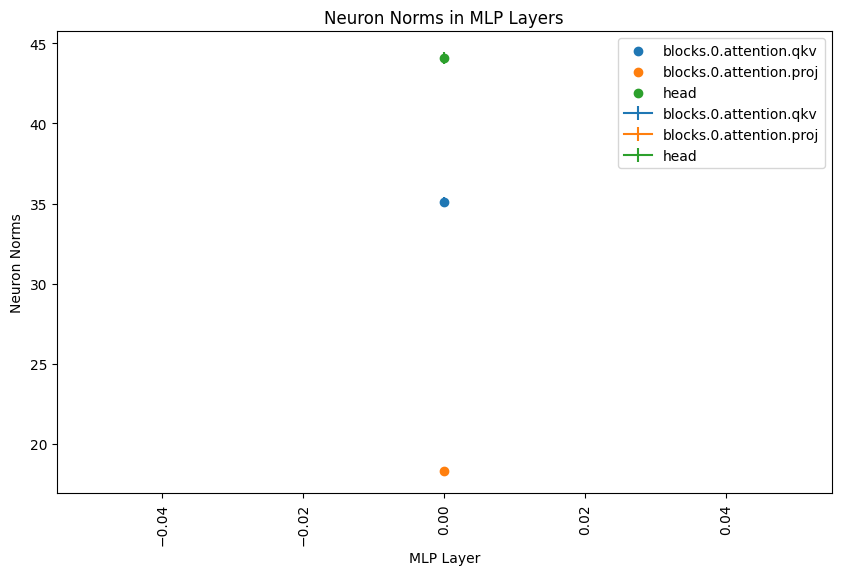

In [244]:
# Assuming the MLP layers are defined within the TransformerBlock in your model as 'mlp'

# Function to compute norms for each neuron in a fully connected layer
def compute_neuron_norms(fc_layer):
    if hasattr(fc_layer, 'weight'):
        # Extract the weight matrix
        weight_matrix = fc_layer.weight.data

        # Compute L2 norm for each neuron (each row in the weight matrix)
        neuron_norms = torch.norm(weight_matrix, dim=1, p=2)

        # Compute standard deviation of the norms
        std_of_norms = torch.std(neuron_norms)

        neuron_norms = torch.norm(weight_matrix)

        return neuron_norms, std_of_norms # Return empty tensor if no weights

# Collect neuron norms for each MLP layer
def other_layer_norms(model):
    all_mean_norms = defaultdict(list)
    all_std_norms = defaultdict(list)
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):  # Assuming MLP layers are Linear layers
            neuron_norms, std_norms = compute_neuron_norms(module)
            if neuron_norms.numel() > 0:  # If the layer has neurons
                all_mean_norms[module_name] = neuron_norms
                all_std_norms[module_name] = std_norms
    return all_mean_norms, all_std_norms

# Plotting
plt.figure(figsize=(10, 6))

all_mean_norms, all_std_norms = other_layer_norms(model)

print(all_mean_norms)
print(all_std_norms)

# Plot mean neuron norms
for layer_name, neuron_norms in all_mean_norms.items():
    plt.errorbar(0, neuron_norms.detach().cpu().numpy(), label=layer_name, yerr=all_std_norms[layer_name].detach().cpu().numpy())
    plt.scatter(0, neuron_norms.detach().cpu().numpy(), label=layer_name)


plt.xlabel('MLP Layer')
plt.ylabel('Neuron Norms')
plt.xticks(rotation=90)
plt.title('Neuron Norms in MLP Layers')
plt.legend()
plt.show()


In [131]:
model.patch_embedding.proj.weight.shape

torch.Size([128, 1, 4, 4])

tensor(13.2784, grad_fn=<NormBackward1>)


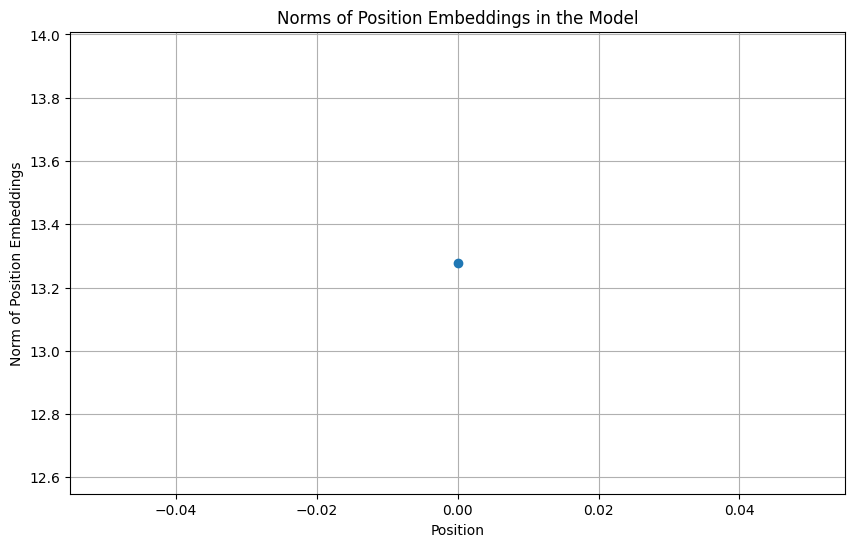

In [143]:
# Compute the L2 norm for each position embedding vector
def get_position_embedding_norms(model):
    position_embeddings = model.position_embedding.cpu().detach()
    print(position_embeddings.shape)
    position_embedding_norms = torch.norm(position_embeddings, dim=-1)

    return position_embedding_norms

def get_patch_embedding_norms(model):
    patch_embeddings = model.patch_embedding.proj.weight
    weight_norm = torch.norm(patch_embeddings)
    return weight_norm

# position_embedding_norms = get_position_embedding_norms(model)

patch_embedding_norms = get_patch_embedding_norms(model)
print(patch_embedding_norms)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(patch_embedding_norms.detach().numpy(), marker='o')


plt.xlabel('Position')
plt.ylabel('Norm of Position Embeddings')
plt.title('Norms of Position Embeddings in the Model')
plt.grid(True)
plt.show()

# Check position embeddings l2

In [248]:
import os
import torch
import re

import numpy as np

# Directory containing the checkpoints

# List all files in the directory
all_files = os.listdir(weight_dir)

# Regular expression to match the file format 'model_{number}.pth'
pattern = re.compile(r'model_(\d+)\.pth')

# Filter and sort the files
# sorted_files = sorted([f for f in all_files if regex.match(f)], key=lambda x: int(regex.match(x).group(1)))

# Filter and sort the files
cutoff = 20000000
sorted_files = sorted(
    [f for f in all_files if pattern.match(f) and int(pattern.findall(f)[0]) <= cutoff],
    key=lambda x: int(pattern.findall(x)[0])
)
checkpoint_numbers = [int(pattern.findall(filename)[0]) for filename in sorted_checkpoint_files]

num_checkpoints = len(sorted_files)

pos_norms = np.zeros((64, num_checkpoints))
patch_norms = []

all_other_norms = []

# Load each checkpoint
for i, filename in enumerate(sorted_files):

    
    checkpoint_path = os.path.join(weight_dir, filename)
    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    # Assuming 'model' is your model instance
    model.load_state_dict(checkpoint['model_state_dict'])
    # print(f"Loaded checkpoint '{filename}'")

    norms = get_position_embedding_norms(model).numpy()
    pos_norms[:, i] = norms
    
    patch_norms.append(get_patch_embedding_norms(model).detach().numpy())

    other_norms, std_norms = other_layer_norms(model)
    all_other_norms.append(other_norms)

    

torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])


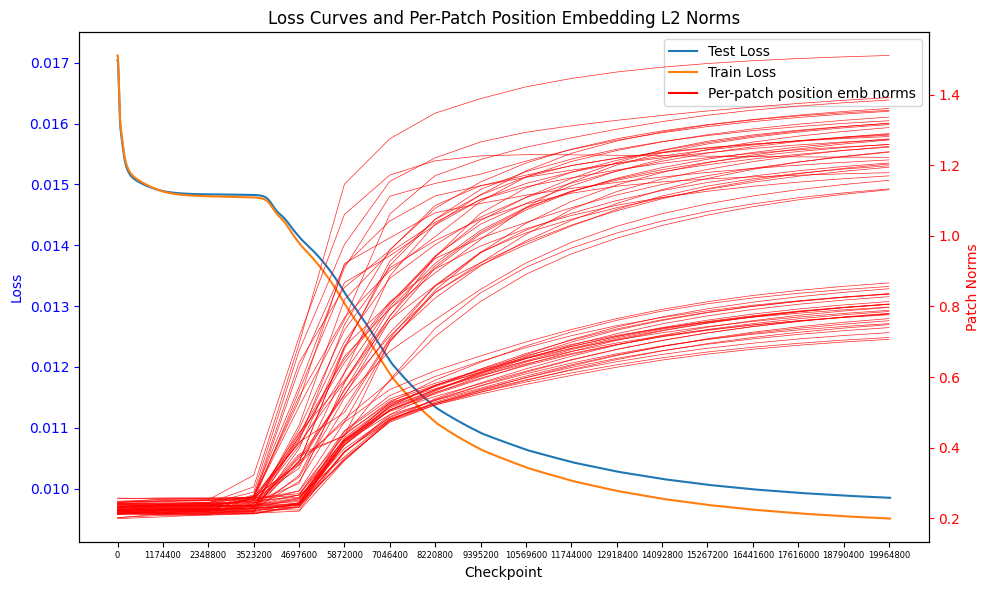

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


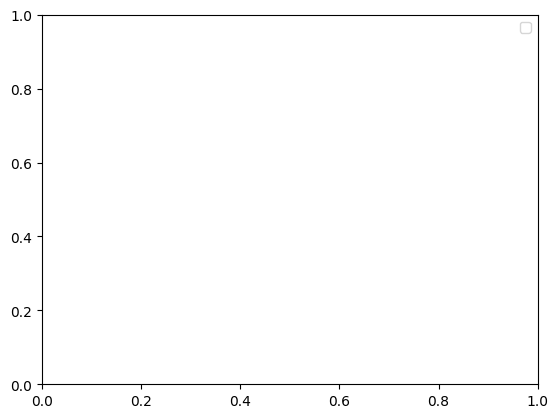

In [151]:
# Load and plot loss curve csv file
test_df = pd.read_csv(weight_dir + '/test_loss_curve.csv')
# Get all values of step less than cutoff
test_df = test_df[test_df["Step"] <= cutoff]

train_df = pd.read_csv(weight_dir + '/train_loss_curve.csv')
train_df = train_df[train_df["Step"] <= cutoff]

# Creating figure and axis objects with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the loss curve
ax1.plot(test_df["Step"], test_df["silver-jazz-185 - test_loss"], label="Test Loss")
ax1.plot(train_df["Step"], train_df["silver-jazz-185 - train_loss"], label="Train Loss")

ax1.set_xlabel('Checkpoint')

ax1.tick_params(axis='x', labelsize=6)  # Making x-axis labels smaller

ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xticks(checkpoint_numbers)  # Setting x-ticks to actual step values
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))  # Format as integers

ax1.plot([], [], color='r', label='Per-patch position emb norms')

# plt legend
ax1.legend(loc='upper right')

# Creating a second y-axis for patch_norms
ax2 = ax1.twinx()


# Plot patches
for i in range(64):
    # make line very skinny
    ax2.plot(checkpoint_numbers, pos_norms[i, :], linewidth=.5, color='r', alpha=0.86)
    # ax2.plot(checkpoint_numbers, patch_norms[i, :], label=f'Position {i+1}', color='r')
    # ax2.scatter(checkpoint_numbers, patch_norms[i, :], label=f'Position {i+1}')


ax2.set_ylabel('Patch Norms', color='r')
ax2.tick_params('y', colors='r')



plt.title("Loss Curves and Per-Patch Position Embedding L2 Norms")
fig.tight_layout()
plt.show()

plt.legend()


# Check patch embeddings

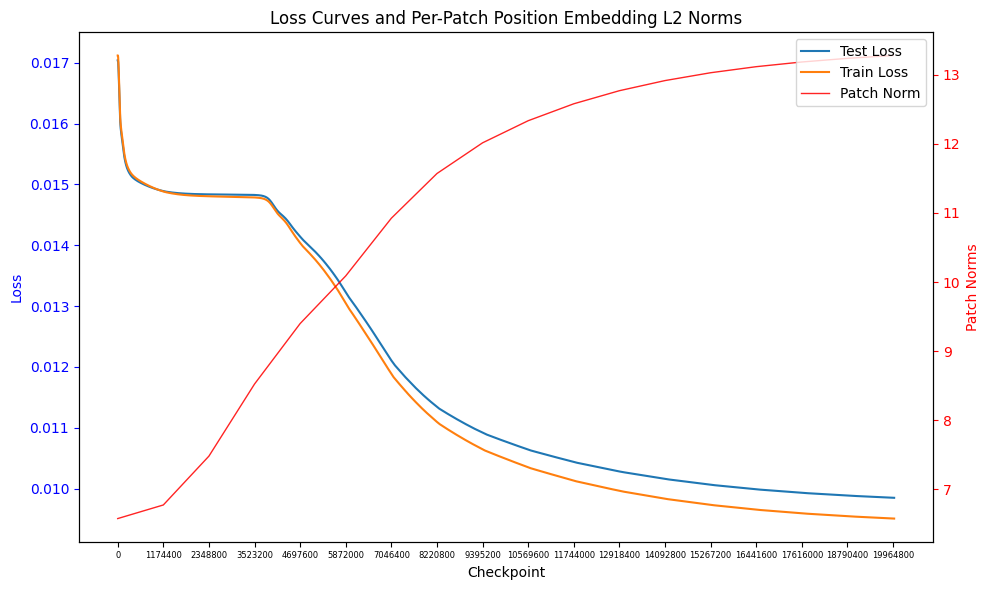

In [162]:
# Load and plot loss curve csv file
test_df = pd.read_csv(weight_dir + '/test_loss_curve.csv')
# Get all values of step less than cutoff
test_df = test_df[test_df["Step"] <= cutoff]

train_df = pd.read_csv(weight_dir + '/train_loss_curve.csv')
train_df = train_df[train_df["Step"] <= cutoff]

# Creating figure and axis objects with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the loss curve
ax1.plot(test_df["Step"], test_df["silver-jazz-185 - test_loss"], label="Test Loss")
ax1.plot(train_df["Step"], train_df["silver-jazz-185 - train_loss"], label="Train Loss")

ax1.set_xlabel('Checkpoint')

ax1.tick_params(axis='x', labelsize=6)  # Making x-axis labels smaller

ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xticks(checkpoint_numbers)  # Setting x-ticks to actual step values
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))  # Format as integers

# plt legend
# ax1.legend(loc='upper right')

# Creating a second y-axis for patch_norms
ax2 = ax1.twinx()


ax2.plot(checkpoint_numbers, patch_norms, linewidth=1, color='r', alpha=0.86, label='Patch Norm')
ax2.set_ylabel('Patch Norms', color='r')
ax2.tick_params('y', colors='r')


# set legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Loss Curves and Per-Patch Position Embedding L2 Norms")
fig.tight_layout()
plt.show()



# Check attention + head norms

In [255]:
layers = ['blocks.0.attention.qkv', 'blocks.0.attention.proj', 'head']
norms = {layer: [] for layer in layers}

for checkpoint in all_other_norms:
    for layer in layers:
        norms[layer].append(checkpoint[layer].cpu().item())  # Convert tensor to a regular number


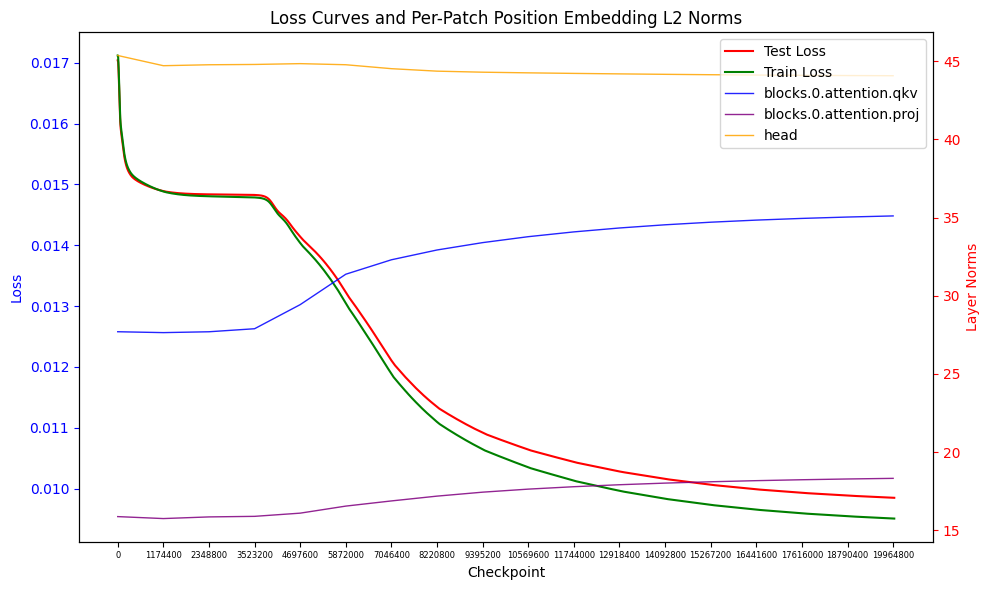

In [265]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data loading and processing code
# ...

# Custom colors for each layer
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray']
color_iter = iter(colors)

# Creating figure and axis objects with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the loss curve
ax1.plot(test_df["Step"], test_df["silver-jazz-185 - test_loss"], label="Test Loss", color=next(color_iter))
ax1.plot(train_df["Step"], train_df["silver-jazz-185 - train_loss"], label="Train Loss", color = next(color_iter))

ax1.set_xlabel('Checkpoint')
ax1.tick_params(axis='x', labelsize=6)
ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xticks(checkpoint_numbers)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))

# Creating a second y-axis for layer norms
ax2 = ax1.twinx()

# Plotting each layer with a different color
for layer, values in norms.items():
    ax2.plot(checkpoint_numbers, values, label=layer, linewidth=1, alpha=0.86, color=next(color_iter))

ax2.set_ylabel('Layer Norms', color='r')
ax2.tick_params('y', colors='r')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Loss Curves and Per-Patch Position Embedding L2 Norms")
fig.tight_layout()
plt.show()
